In [1]:
from dotenv import load_dotenv
from pathlib import Path 
import os
import openai
from openai import AzureOpenAI

env_path = Path('.') / 'secrets.env'
load_dotenv(dotenv_path=env_path)

api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")
import openai
client = AzureOpenAI(
  api_key=os.environ.get("AZURE_OPENAI_API_KEY"),  
  api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
  azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT"),
)


### Data preparation 

Organize video files under video folder (.mp4 files).
Make sure each video file is in a seperate folder with the same name with video file withtout extension. For example videos/car_street1/car_street1.mp4

In [2]:
from scenedetect import detect, AdaptiveDetector
from PIL import Image
import cv2
import numpy as np



c:\Users\janguy\AppData\Local\anaconda3\envs\genai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from openai import AzureOpenAI
import base64
client = AzureOpenAI(
  api_key=os.environ.get("AZURE_OPENAI_API_KEY"),  
  api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
  azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT"),
)
  
def encode_image(image_path):  
    with open(image_path, "rb") as image_file:  
        return base64.b64encode(image_file.read()).decode('utf-8')  
  
def get_gpt_response(prompt, image_paths=None, max_tokens=600, json_output=False):  
    # Encode images to base64  
      
    # Prepare the message content  
    message_content = [{"type": "text", "text": prompt}]  
    if image_paths:
        base64_images = [encode_image(image_path) for image_path in image_paths]  

        for base64_image in base64_images:  
            message_content.append({  
                "type": "image_url",  
                "detail": "low",  
                "image_url": {  
                    "url": f"data:image/jpeg;base64,{base64_image}",  
                },  
            })  
        
    if json_output:  

        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
            messages=[  
                {  
                    "role": "user",  
                    "content": message_content,  
                }  
            ],  
            max_tokens=max_tokens,  
            response_format={ "type": "json_object" }
            
        )  
    else:
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
            messages=[  
                {  
                    "role": "user",  
                    "content": message_content,  
                }  
            ],  
            max_tokens=max_tokens,  
            
        )  

      
    # Return the response content  
    return response.choices[0].message.content  
  


In [7]:
import os  
import cv2  
import json  
import numpy as np  
from PIL import Image  
from scenedetect import detect, AdaptiveDetector  
import concurrent.futures  
  
  
def get_frames_from_scene(scene, video_capture, n):  
    start_frame = scene[0].frame_num  
    end_frame = scene[1].frame_num  
    frame_step = (end_frame - start_frame) // (n + 1)  
  
    frames = []  
    frame_ids = []  
  
    for i in range(1, n + 1):  
        frame_id = start_frame + i * frame_step  
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_id)  
        _, frame = video_capture.read()  
        frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))  
        frame_ids.append(frame_id)  
  
    return frame_ids, frames  
  
def save_frame_image(frame, output_path):  
    frame.save(output_path)  
  
def get_frame_time(video_capture, frame_id):  
    fps = video_capture.get(cv2.CAP_PROP_FPS)  
    seconds = frame_id / fps  
    return seconds  
  
def extract_description(image_path):  
    return get_gpt_response(prompt="This is my personal photograph for evaluation. Please describe the content within the picture frame. If there are any vehicles, identify their make, type, model, and license plate if discernible. For any humans present, detail their gender, appearance, attire, and approximate age, as well as any other distinguishable features. If there are street signs, note the street names and numbers if they are legible. If any of the specified details are not visible, simply provide a general description of the visible elements.No need to add comment such as some element is not visible", image_paths=[image_path])  
  
def get_frames_from_video(video_path, output_folder, n):  
    res = []  
    video_capture = cv2.VideoCapture(video_path)  
    content_list = detect(video_path, AdaptiveDetector(adaptive_threshold=1.01, window_width=3))  
    frame_to_video_mapping = {}  
  
    with concurrent.futures.ThreadPoolExecutor(max_workers=7) as executor:  
        future_to_frame = {}  
  
        for scene_idx, scene in enumerate(content_list):  
            frame_ids, frames = get_frames_from_scene(scene, video_capture, n)  
            start_time = scene[0].get_timecode()  
            end_time = scene[1].get_timecode()  
  
            for frame_num, (frame_id, frame) in enumerate(zip(frame_ids, frames)):  
                frame_filename = f"scene_{scene_idx+1}_frame_{frame_id}_{frame_num+1}.jpg"  
                frame_output_path = os.path.join(output_folder, frame_filename)  
                save_frame_image(frame, frame_output_path)  
  
                future = executor.submit(extract_description, frame_output_path)  
                future_to_frame[future] = frame_filename  
  
        for future in concurrent.futures.as_completed(future_to_frame):  
            frame_filename = future_to_frame[future]  
            try:  
                description = future.result()  
                frame_to_video_mapping[frame_filename] = {  
                    "video_file": os.path.basename(video_path),  
                    "frame_time": get_frame_time(video_capture, int(frame_filename.split('_')[3])),  
                    "description": description  
                }  
            except Exception as e:  
                print(f"Error processing {frame_filename}: {e}")  
  
    return frame_to_video_mapping  
  
def process_videos_in_folder(input_folder, n):  
    frame_to_video_mapping = {}  
  
    for subdir, _, files in os.walk(input_folder):  
        for file in files:  
            if file.endswith(('.mp4', '.avi', '.mov', '.MOV', '.mkv')):  
                video_path = os.path.join(subdir, file)  
  
                video_frame_mapping = get_frames_from_video(video_path, subdir, n)  
                frame_to_video_mapping.update(video_frame_mapping)  
      
    json_output_path = os.path.join("processed_data", 'frame_to_video_mapping.json')  
    with open(json_output_path, 'w') as json_file:  
        json.dump(frame_to_video_mapping, json_file, indent=4)  
  
input_folder = "videos"  # Change this to your input folder path  
n_frames = 3  # Change this to the number of frames you want to extract from each scene  
process_videos_in_folder(input_folder, n_frames)  


In [10]:
import os  
import json  
import concurrent.futures  
from functools import partial  
  
# Function to get running summary  
def get_running_summary(video_prompt, image_paths, chunk_size=10):  
    overall_summary = ""  
    num_chunks = (len(image_paths) + chunk_size - 1) // chunk_size  # Calculate the number of chunks  
  
    for i in range(num_chunks):  
        chunk_image_paths = image_paths[i * chunk_size:(i + 1) * chunk_size]  
        # Append the previous summary to the prompt  
        extended_prompt = f"{video_prompt}\n\Summary of the content so far: {overall_summary}"  
        chunk_summary = get_gpt_response(extended_prompt, chunk_image_paths)  
        # Update the overall summary  
        overall_summary += f" {chunk_summary}"  
  
    return overall_summary.strip()  # Remove any leading/trailing whitespace  
  
# Function to process a single video folder  
def process_video_folder(video_folder, output_folder, frame_prompt):  
    video_folder_path = os.path.join(output_folder, video_folder)  
  
    if os.path.isdir(video_folder_path):  
        video_summary = {  
            "video_file_name": video_folder,  
            "overall_summary": "",  
            "frames": []  
        }  
  
        # List to store paths of images for the entire video  
        all_image_paths = []  
  
        # Iterate through all images in the current video folder  
        for img_file in sorted(os.listdir(video_folder_path)):  
            if img_file.endswith('.jpg'):  
                img_path = os.path.join(video_folder_path, img_file)  
                all_image_paths.append(img_path)  
  
                # Get and store summary for the current page  
                frame_summary = get_gpt_response(frame_prompt, [img_path])  
                video_summary["frames"].append({  
                    "frame": img_file.split('scene_')[1].split('.')[0],  # Extract page number from filename  
                    "summary": frame_summary  
                })  
  
        # Get and store overall summary for the video using the running summary method  
        overall_summary = get_running_summary(video_prompt, all_image_paths)  
        video_summary["overall_summary"] = overall_summary  
  
        return video_summary  
  
# Define the folder where your processed images are stored  
output_folder = 'videos'  
  
# Prompt for summarizing  
frame_prompt = "Describe  content of this picture frame. If there are cars, note down type, model, license plate. If there are humans, note down their gender, apperance, clothes, age, what they wear. If there are street signs, note down street name and numbers"  
video_prompt = "Summarize the video content given the new video frames and the summary of the video so far "
  
# Initialize the final output structure  
final_output = []  
  
# Get a list of all video subfolders in the output folder  
video_folders = [video_folder for video_folder in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, video_folder))]  
  
# Process folders in parallel with a maximum of 4 concurrent tasks  
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:  
    # Use partial to fix output_folder and prompt arguments  
    process_func = partial(process_video_folder, output_folder=output_folder, frame_prompt=frame_prompt)  
      
    # Submit tasks and collect results  
    futures = {executor.submit(process_func, video_folder): video_folder for video_folder in video_folders}  
      
    for future in concurrent.futures.as_completed(futures):  
        video_folder = futures[future]  
        try:  
            video_summary = future.result()  
            final_output.append(video_summary)  
            print(f'Processed {video_folder}')  
        except Exception as e:  
            print(f'Error processing {video_folder}: {e}')  
  
# Save the final output to a JSON file  
with open(os.path.join("processed_data", 'video_summaries.json'), 'w') as json_file:  
    json.dump(final_output, json_file, indent=4)  
  
print('Finished processing all video files and saved summaries to video_summaries.json.')  


Processed car_street1
Processed car_street2
Processed chrome_ads
Finished processing all video files and saved summaries to video_summaries.json.


### Chunking content in each file into topics


In [12]:
import uuid
with open("processed_data/video_summaries.json", "r") as f:
    initial_data = json.load(f)
output_data =[]
prompt_template = """
Review the structured content of the document below and chunk the content further into multiple topics. 
Give response in JSON format with topic content and the corresponding page numbers like this {{"topic 1 content": "1,2,3","topic 2 content": "3,4,5"}}
page numbers must be comma seperated page numbers, do not give a range. both topic and page numbers must not be blank.
### Content
{content}
"""
import json  
import concurrent.futures  
from functools import partial  
  
# Function to process a single file  
def process_file(file, prompt_template):  
    prompt = prompt_template.format(content=file)  
    topic_chunk = json.loads(get_gpt_response(prompt, json_output=True))  
    for topic, pages in topic_chunk.items():
        pages = pages.split(",")
        frame_content = [page for page in file['frame'] if str(page['frame_number']) in pages]
        if len(frame_content)==0:
            print(pages)

        topic_chunk[topic] = frame_content
      
    new_file_content = {  
        'video_file_name': file['video_file_name'],  
        'overall_summary': file['overall_summary'],  
        'topics': topic_chunk  
    }  
      
    return new_file_content  
  
  
# Output list to store processed data  
output_data = []  
  
# Process files in parallel with a maximum of 4 concurrent tasks  
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:  
    process_func = partial(process_file, prompt_template=prompt_template)  
      
    # Submit tasks and collect results  
    futures = {executor.submit(process_func, file): file for file in initial_data}  
      
    for future in concurrent.futures.as_completed(futures):  
        file = futures[future]  
        try:  
            new_file_content = future.result()  
            output_data.append(new_file_content)  
        except Exception as e:  
            print(f'Error processing file {file["video_file_name"]}: {e}')  
  
# Save the final output to a JSON file  
with open("processed_data/chunked_data.json", "w") as f:  
    json.dump(output_data, f, indent=4)  
  
print('Finished processing all files and saved summaries to chunked_data.json.')  




Error processing file car_street1: 'pages'
Error processing file car_street2: 'pages'
Error processing file chrome_ads: 'pages'
Finished processing all files and saved summaries to chunked_data.json.


### Ingest and index documents 

In [8]:
def extract_index(prompt, taxonomy_path, document_content):  
    # Encode images to base64  
    base64_taxonomy = encode_image(taxonomy_path) 
    document_content = "### Document content\n\n"+document_content
      
    # Prepare the message content  
    message_content = [{"type": "text", "text": prompt}]  
    message_content.append({  
        "type": "image_url",  
        "detail": "low",  
        "image_url": {  
            "url": f"data:image/jpeg;base64,{base64_taxonomy}",  
        },  
    })  
    message_content.append({"type": "text", "text": document_content})
    # Make the API request  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {  
                "role": "user",  
                "content": message_content,  
            }  
        ],  
        max_tokens=500,  
        response_format={"type": "json_object"}
        
    )  
      
    # Return the response content  
    return response.choices[0].message.content  


### Extract entities and relationships

## Ingest images data into AI Search


In [9]:
### Ingest images data into AI Search

from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import *
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchFieldDataType,
    SearchableField,
    SearchField,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SemanticConfiguration,
    SemanticPrioritizedFields,
    SemanticField,
    SemanticSearch,
    SearchIndex,
    
)

from pathlib import Path  
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential  
def create_search_index(index_name, searchservice):
    
    index_client = SearchIndexClient(endpoint=searchservice,
                                     credential=AzureKeyCredential(os.getenv("AZURE_SEARCH_KEY")))
    if index_name  in index_client.list_index_names():
        print(f"Search index {index_name} already exists, will now recreate it")
        index_client.delete_index(index_name)
    

    fields=[SimpleField(name="id", type=SearchFieldDataType.String, key=True),
            SimpleField(name="file_name", type=SearchFieldDataType.String),
            SimpleField(name="frame_filename", type=SearchFieldDataType.String),
            SimpleField(name="frame_time", type=SearchFieldDataType.Double),

            SearchableField(name="description", type=SearchFieldDataType.String),
            SearchField(name="contentVector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
            hidden=False, searchable=True, filterable=False, sortable=False, facetable=False,
            vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile"),       
            SearchField(name="imageVector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single), 
            hidden=False, searchable=True, filterable=False, sortable=False, facetable=False,
            vector_search_dimensions=1024, vector_search_profile_name="myHnswProfile"),    
            ]

    index = SearchIndex(
        name=index_name,
        fields=fields,


        # Create the semantic settings with the configuration
        semantic_search = SemanticSearch(configurations=[SemanticConfiguration(
            name="my-semantic-config",
            prioritized_fields=SemanticPrioritizedFields(
                title_field=SemanticField(field_name="description"),
                content_fields=[SemanticField(field_name="description")]
            )
        )]),
            vector_search = VectorSearch(
                algorithms=[
                    HnswAlgorithmConfiguration(
                        name="myHnsw"
                    )
                ],
                profiles=[
                    VectorSearchProfile(
                        name="myHnswProfile",
                        algorithm_configuration_name="myHnsw",
                    )
                ]
                        )
    )
    index_client.create_or_update_index(index)
    print(f"Search index {index_name} created successfully")


index = os.getenv("AZURE_SEARCH_INDEX_NAME")
searchkey = os.getenv("AZURE_SEARCH_KEY")
openaikey = os.getenv("AZURE_OPENAI_API_KEY")
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")
searchservice= os.getenv("AZURE_SEARCH_ENDPOINT")

client = AzureOpenAI(
api_key=openaikey,  
api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
azure_endpoint = openaiservice
)

create_search_index(index_name=index,  searchservice=searchservice)


Search index video_search already exists, will now recreate it
Search index video_search created successfully


In [13]:
import json
import uuid  
import time
# Function to get embeddings  
def get_text_embedding(text, model=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT")):  
    text = text.replace("\n", " ")  
    while True:  
        try:  
            embedding_response = client.embeddings.create(input = [text], model=model).data[0].embedding
            return embedding_response  
        except openai.error.RateLimitError:  
            print("Rate limit exceeded. Retrying after 10 seconds...")  
            time.sleep(10)  

import os
from dotenv import load_dotenv
import requests

# Load environment variables
load_dotenv("secrets.env")
endpoint = os.getenv("AZURE_AI_VISION_ENDPOINT") + "computervision/"

def get_image_embedding(image):
    with open(image, "rb") as img:
        data = img.read()

    # Vectorize Image API
    version = "?api-version=2024-02-01&modelVersion=latest"
    vectorize_img_url = endpoint + "retrieval:vectorizeImage" + version

    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key
    }

    try:
        r = requests.post(vectorize_img_url, data=data, headers=headers)

        if r.status_code == 200:
            image_vector = r.json()["vector"]
            return image_vector
        else:
            print(f"An error occurred while processing {image}. Error code: {r.status_code}.")

    except Exception as e:
        print(f"An error occurred while processing {image}: {e}")

    return None

def get_text_embedding_mm(text):
    key = os.getenv("AZURE_AI_VISION_API_KEY")

    # Vectorize Image API
    version = "?api-version=2024-02-01&model-version=2023-04-15"
    vectorize_img_url = endpoint + "retrieval:vectorizeText" + version
    data = json.dumps({"text":text})
    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": key
    }

    try:
        r = requests.post(vectorize_img_url, data=data, headers=headers)

        if r.status_code == 200:
            image_vector = r.json()["vector"]
            return image_vector
        else:
            print(f"An error occurred while processing {text}. Error code: {r.status_code}.")

    except Exception as e:
        print(f"An error occurred while processing {text}: {e}")

    return None
def get_image_embedding(image):
    with open(image, "rb") as img:
        data = img.read()
    key = os.getenv("AZURE_AI_VISION_API_KEY")
    # Vectorize Image API
    version = "?api-version=2024-02-01&model-version=2023-04-15"
    vectorize_img_url = endpoint + "retrieval:vectorizeImage" + version

    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key
    }

    try:
        r = requests.post(vectorize_img_url, data=data, headers=headers)

        if r.status_code == 200:
            image_vector = r.json()["vector"]
            return image_vector
        else:
            print(f"An error occurred while processing {image}. Error code: {r.status_code}.")

    except Exception as e:
        print(f"An error occurred while processing {image}: {e}")

    return None





In [14]:
import json  
import os  
import uuid  
from concurrent.futures import ThreadPoolExecutor, as_completed  
  
# Assume get_text_embedding and get_image_embedding are defined elsewhere  
# from your_module import get_text_embedding, get_image_embedding  
  
def process_frame(frame_filename, data):  
    new_item = {}  
    new_item['id'] = str(uuid.uuid4())  
    new_item['file_name'] = data['video_file']  
    new_item['frame_filename'] = frame_filename  
    new_item['frame_time'] = data['frame_time']  
    new_item['description'] = data['description']  
  
    # Get embeddings  
    new_item['contentVector'] = get_text_embedding(new_item['description'])  
    frame_image_file = os.path.join("videos", new_item['file_name'].split(".")[0], frame_filename)  
    new_item['imageVector'] = get_image_embedding(frame_image_file)  
  
    return new_item  
  
# Load the mapping output JSON file  
with open("processed_data/frame_to_video_mapping.json", "r") as f:  
    frame_to_video_mapping = json.load(f)  
  
output_data = []  
  
# Use ThreadPoolExecutor to process frames in parallel  
with ThreadPoolExecutor(max_workers=8) as executor:  
    future_to_frame = {executor.submit(process_frame, frame_filename, data): frame_filename for frame_filename, data in frame_to_video_mapping.items()}  
  
    for future in as_completed(future_to_frame):  
        try:  
            new_item = future.result()  
            output_data.append(new_item)  
        except Exception as exc:  
            print(f'Generated an exception: {exc}')  
  
# Save the processed data to a new JSON file  
with open("processed_data/output_data_with_embeddings.json", "w") as f:  
    json.dump(output_data, f, indent=4)  


In [15]:
from azure.search.documents import SearchClient  
index = os.getenv("AZURE_SEARCH_INDEX_NAME")
searchkey = os.getenv("AZURE_SEARCH_KEY")
searchservice= os.getenv("AZURE_SEARCH_ENDPOINT")
with open("processed_data/output_data_with_embeddings.json", "r") as f:
            loaded_output = json.load(f)  

search_client = SearchClient(  
        endpoint=searchservice,  
        index_name=index,  
        credential=AzureKeyCredential(searchkey)  
    )  
search_client.upload_documents(loaded_output)  


## Query Testing

file_name: traffic_cam2.mp4
frame_filename: scene_2_frame_1076_1.jpg
description: The photograph captures a street intersection. A few key elements within the frame are notable:

1. **Vehicles:**
    - **Pickup Truck:** There is a red pickup truck on the left side. 
    - **Motorcycle:** A person on a motorcycle is visible in the center part of the intersection.
    - **Truck:** A grey truck with a number "88C 107.99" is prominently positioned in the lower right quadrant of the image.
    - **Another Car:** A white car is visible at the lower left corner of the image.
2. **Humans:**
    - A person riding the motorcycle wears a purple top and a red helmet.
3. **Street Features:**
    - A crosswalk is visible in the center of the image.
    - There are traffic lights at various parts of the intersection.
    - Additional street signs indicating traffic directions and regulations are visible.

Other features observed include road markings and trees near the crosswalk area.


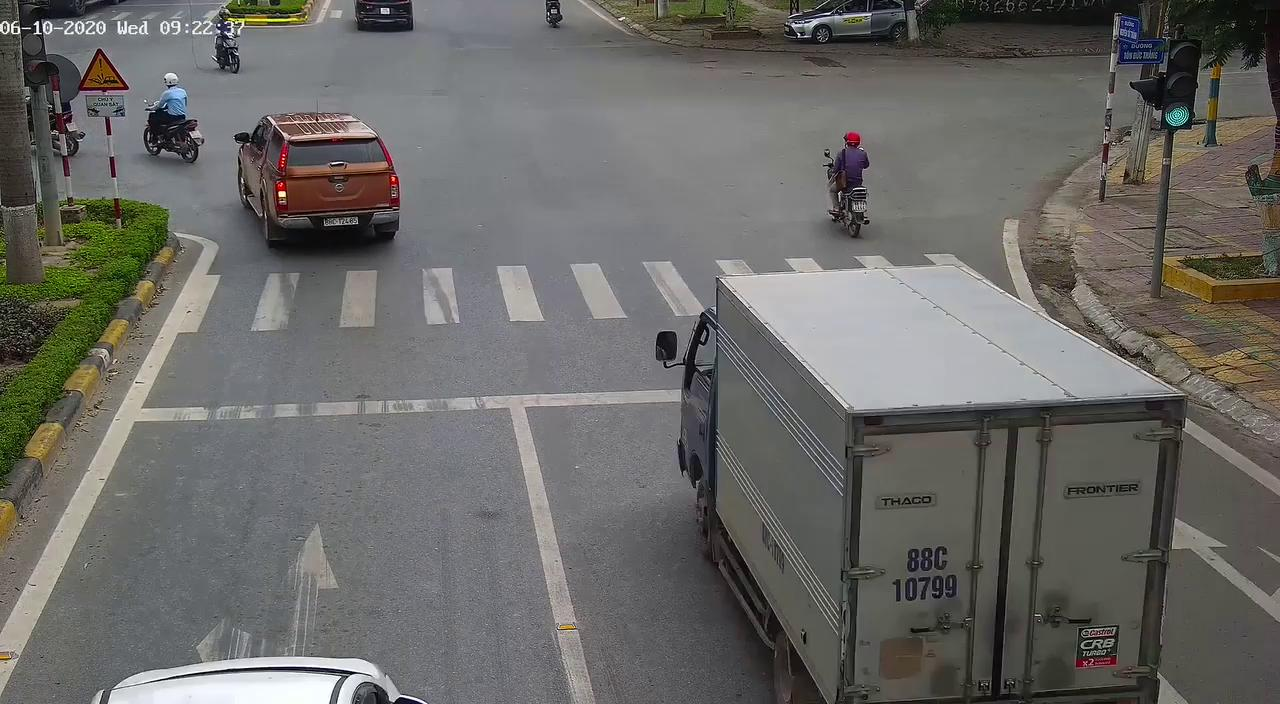

file_name: car_street1.MOV
frame_filename: scene_107_frame_2209_1.jpg
description: The photograph depicts a suburban neighborhood scene on a bright, clear day. 

The following elements are visible within the picture frame:
- Vehicles: Several vehicles are parked along the street. Specifically, there is a white SUV parked on the left side of the image, along with another dark-colored vehicle (possibly a black SUV) next to it. On the right side of the image, there is a grey pickup truck parked along the side of the road.

- Street and Surroundings: The residential street is lined with well-kept trees and shrubs, and the houses are two-story buildings with neat lawns. Sidewalks and street lamps are also visible.

- Lighting: It is a sunny clear day, casting bright and sharp shadows. 

- Foliage: Green leafy trees are aligned along the edges of the road, suggesting a well-maintained and verdant neighborhood.

No license plates, humans, or any other prominent features such as street signs o

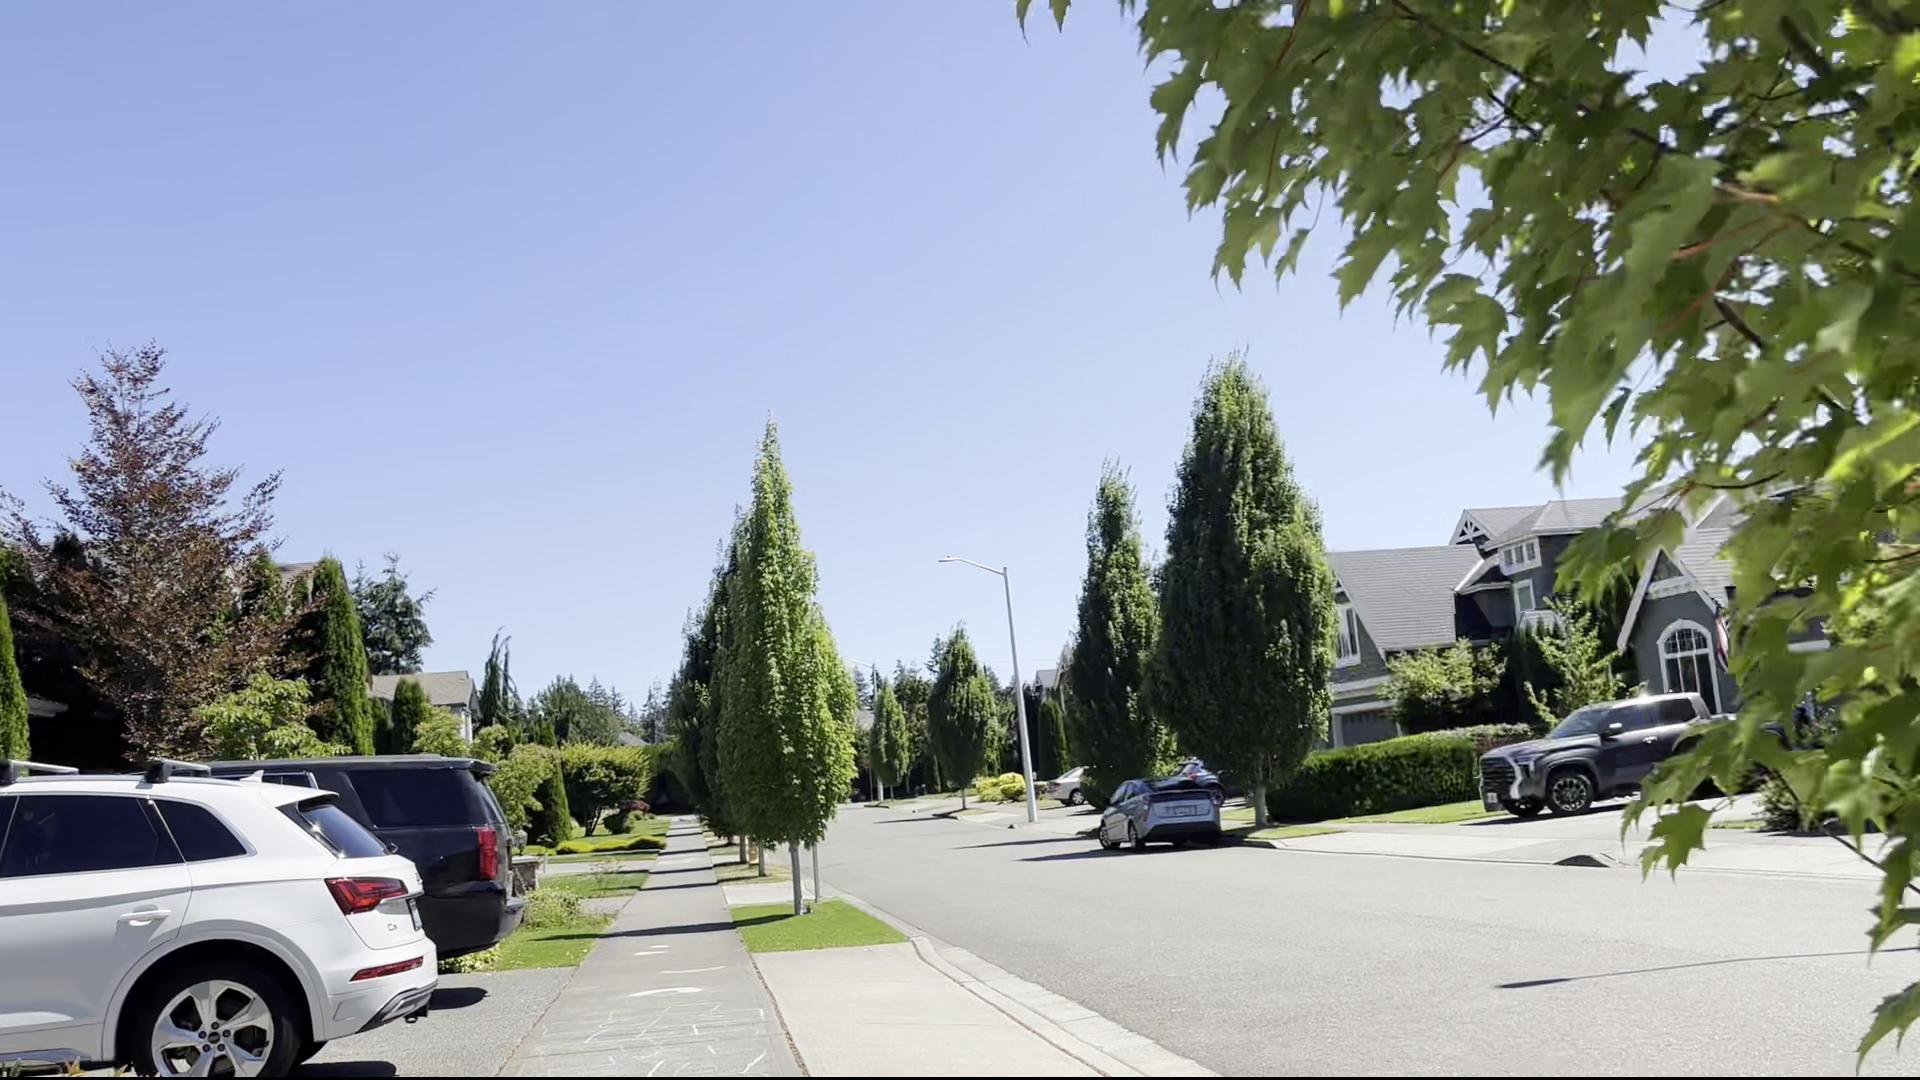

file_name: car_street1.MOV
frame_filename: scene_64_frame_1447_1.jpg
description: The photograph depicts a suburban neighborhood. Here are the observed details:

1. **Vehicles**:
   - **Vehicle 1**: 
     - **Type**: Hatchback car
     - **Color**: Orange
     - **Location**: Parked in the driveway
   - **Vehicle 2**: 
     - **Make**: Jeep
     - **Type**: SUV
     - **Color**: Gray
     - **Location**: Parked on the street in front of the house
   - **Vehicle 3**:
     - **Type**: Moving truck
     - **Color**: Primarily white with a "U-Haul" logo
     - **Location**: Parked in the driveway
   
2. **Houses**:
   - Two main houses are prominently visible.
     - The house to the left is two-story with gray exterior, white trim, and a well-maintained garden in front with green bushes and shrubs.
     - The house to the right is also two-story, with a mix of grey and beige exterior with white windows.

3. **Street and Surrounding Area**:
   - The street appears to be a quiet, residentia

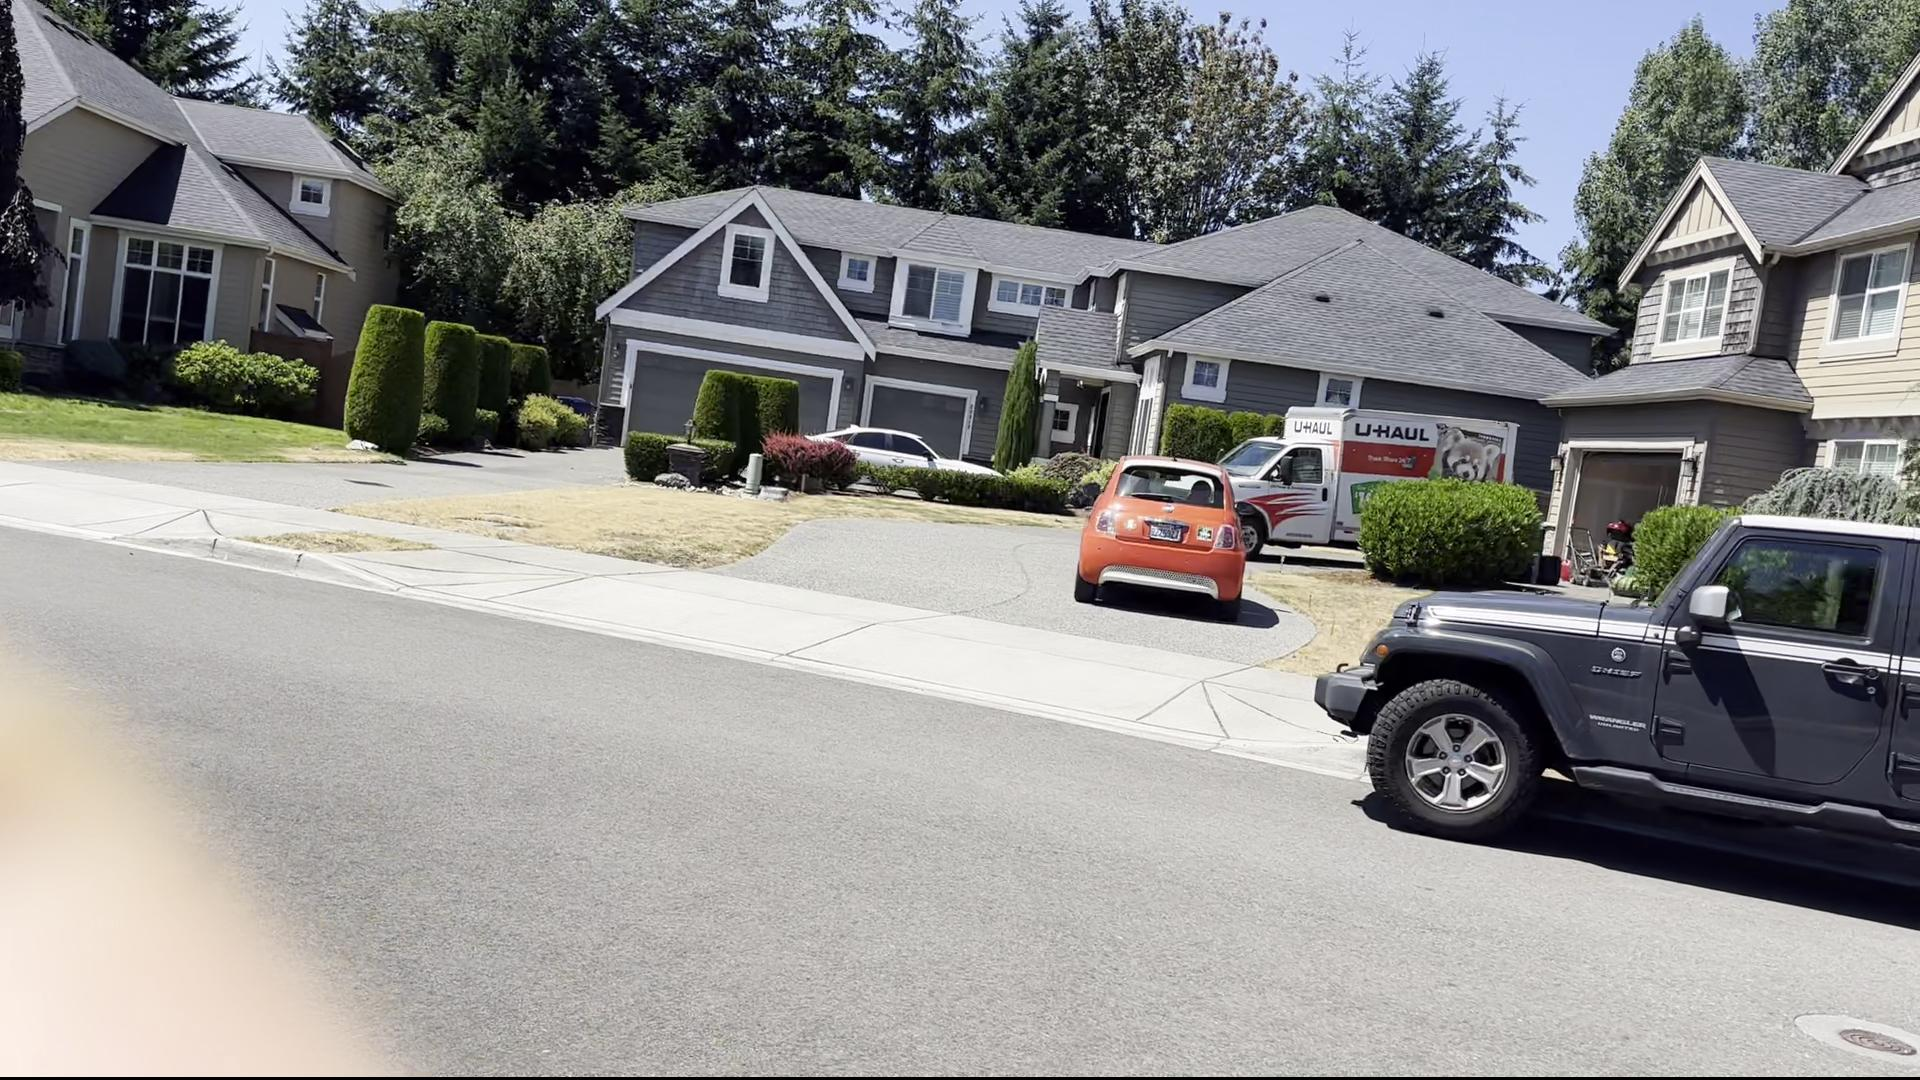

In [28]:
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery,VectorizedQuery

from azure.core.credentials import AzureKeyCredential
from IPython.display import Image
import ast
from azure.search.documents import SearchClient  
from azure.search.documents.models import QueryType, QueryCaptionType, QueryAnswerType

index = os.getenv("AZURE_SEARCH_INDEX_NAME")
searchkey = os.getenv("AZURE_SEARCH_KEY")
searchservice= os.getenv("AZURE_SEARCH_ENDPOINT")

search_client = SearchClient(  
        endpoint=searchservice,  
        index_name=index,  
        credential=AzureKeyCredential(os.getenv("AZURE_SEARCH_KEY"))  
    )  
# Pure Vector Search
# query = "Nescaf brand guidelines for creating a storyboard for an iced latte coffee recipe focusing on innovation"  
query= "THaco truck with frontier"
image_query = VectorizedQuery(vector=get_text_embedding_mm(query), k_nearest_neighbors=3, fields="imageVector")
vector_query = VectorizedQuery(vector=get_text_embedding(query), k_nearest_neighbors=3, fields="contentVector")

# Use the below query to pass in the raw vector query instead of the query vectorization
# vector_query = RawVectorQuery(vector=generate_embeddings(query), k_nearest_neighbors=3, fields="vector")
  
results = search_client.search(  
    search_text=query,  
    query_type=QueryType.SEMANTIC, semantic_configuration_name='my-semantic-config', query_caption=QueryCaptionType.EXTRACTIVE, query_answer=QueryAnswerType.EXTRACTIVE,

    vector_queries= [image_query,vector_query],
    select=[ "file_name", "description", "frame_filename"],
    top=3
)  
images_directory="videos" 

for result in results:  
    print(f"file_name: {result['file_name']}")  
    print(f"frame_filename: {result['frame_filename']}")  

    print(f"description: {result['description']}")  

    image = os.path.join(images_directory,result['file_name'].split(".")[0], result['frame_filename'])
    display(Image(filename=image))

